In [1]:
import argparse
from functools import partial
from glob import glob
from joblib import Parallel, delayed
import json
import nibabel
from nilearn import image
import numpy as np
from os import makedirs, path, sep
import pandas as pd
import pickle
import shutil
import sys

from utils.secondlevel_utils import *
from utils.secondlevel_plot_utils import *

180827-07:01:50,853 duecredit ERROR:
	 Failed to import duecredit due to No module named 'duecredit'


In [2]:
# unnecessary imports, for exploring
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from nilearn import plotting
import warnings
warnings.simplefilter("ignore", UserWarning)

# Parse Arguments
These are not needed for the jupyter notebook, but are used after conversion to a script for production

- conversion command:
  - jupyter nbconvert --to script --execute 2ndlevel_analysis.ipynb

In [4]:
parser = argparse.ArgumentParser(description='fMRI Analysis Entrypoint Script.')
parser.add_argument('-derivatives_dir')
parser.add_argument('-working_dir', default=None)
parser.add_argument('--tasks', nargs="+")
parser.add_argument('--n_procs', default=4, type=int)
parser.add_argument('--num_perm', default=1000, type=int, help="Passed to fsl.randomize")
parser.add_argument('--ignore_rt', action='store_false')
parser.add_argument('--rerun', action='store_true')
parser.add_argument('--mask_threshold', default=.8, type=float)
if '-derivatives_dir' in sys.argv or '-h' in sys.argv:
    args = parser.parse_args()
    num_files = None
else:
    # if run as a notebook reduce the number of files used and set of args
    args = parser.parse_args([])
    args.derivatives_dir='/data/derivatives'
    num_files = None
    args.rerun = False

In [5]:
derivatives_dir = args.derivatives_dir
fmriprep_dir = path.join(derivatives_dir, 'fmriprep', 'fmriprep')
first_level_dir = path.join(derivatives_dir, '1stlevel')
second_level_dir = path.join(derivatives_dir,'2ndlevel')
if args.working_dir is None:
    working_dir = path.join(derivatives_dir, '2ndlevel_workingdir')
else:
    working_dir = path.join(args.working_dir, '2ndlevel_workingdir')
makedirs(working_dir, exist_ok=True)
    
tasks = ['ANT', 'CCTHot', 'discountFix',
         'DPX', 'motorSelectiveStop',
         'stopSignal', 'stroop', 
         'surveyMedley', 'twoByTwo', 'WATT3']
if args.tasks:
    tasks = args.tasks
regress_rt = args.ignore_rt
model = 'model-rt' if regress_rt == True else 'model-nort'
mask_threshold = args.mask_threshold

# Create Group Mask

In [6]:
# create mask over all tasks
# create 95% brain mask
mask_loc = path.join(second_level_dir, 'group_mask_thresh-%s.nii.gz' % str(mask_threshold))
if path.exists(mask_loc) == False:
    create_group_mask(mask_loc, fmriprep_dir, mask_threshold)

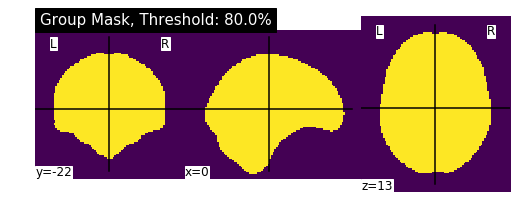

In [7]:
plotting.plot_img(mask_loc, title='Group Mask, Threshold: %s%%' % str(mask_threshold*100))

# Setup

In [8]:
# set up functions with some default parameters
get_group_maps = partial(get_group_maps, second_level_dir=second_level_dir,
                        tasks=tasks, model=model)
get_ICA_parcellation = partial(get_ICA_parcellation, second_level_dir=second_level_dir,
                               mask_loc=mask_loc, working_dir=working_dir)

In [9]:
# get data files
individual_file_type = 'zstat'
map_files = get_map_files(map_prefix=individual_file_type, 
                          first_level_dir=first_level_dir,
                        tasks=tasks, model=model)
contrast_names = list(map_files.keys())
# reduce the number of files to make execution quicker for testing
def random_sample(lst, n):
    return [lst[i] for i in np.random.choice(range(len(lst)), n, replace=False)]
if num_files is not None:
    map_files = {k:random_sample(v, num_files) for k,v in map_files.items()}


No subjectinfo found for stopSignal, Model-model-rt


In [10]:
"""
#iterative version
concat_out = concat_map_files(map_files, file_type=individual_file_type,
                                second_level_dir=second_level_dir, model=model,
                                verbose=True)
"""
# concat files in parallel
concat_map_files = partial(concat_map_files, file_type=individual_file_type,
                           second_level_dir=second_level_dir, model=model, verbose=False,
                          rerun=args.rerun)

list_dicts = [{k:map_files[k]} for k in map_files.keys()]
concat_out = Parallel(n_jobs=args.n_procs)(delayed(concat_map_files)(task) for task in list_dicts)
concat_out = flatten(concat_out)

In [11]:
"""
#iterative version
smooth_out = smooth_concat_files(concated_map_files, verbose=True)
"""
# smooth files in parallel
smooth_concat_files = partial(smooth_concat_files, verbose=False, rerun=args.rerun)
smooth_out = Parallel(n_jobs=args.n_procs)(delayed(smooth_concat_files)([concat_file]) for concat_file in concat_out)
smooth_out = flatten(smooth_out)

# Create Group Maps

In [27]:
# then tmap
contrast_tmap_parallel = partial(save_tmaps, mask_loc=mask_loc, working_dir=working_dir, 
                                 permutations=args.num_perm, rerun=args.rerun)
tmap_out = Parallel(n_jobs=args.n_procs)(delayed(contrast_tmap_parallel)(filey) for filey in smooth_out)
tmap_raw, tmap_correct = zip(*tmap_out)

In [ ]:
# % matplotlib inline
# task_contrast_dirs = sorted(glob(path.join(second_level_dir, '*', 'model-rt', 'wf-contrast')))
# for d in task_contrast_dirs:
#     plot_2ndlevel_maps(d, lookup='*corrected*', threshold=.95) # *raw* for raw

# Parcellations, Atlases and RDM

Projecting into a lower dimensional space allows the evaluation of whole-brain similarity analysis (clustering)

RDMs can also be evaluated within parcellation regions

## Get parcellations to use

In [31]:
parcellation_dir = path.join(second_level_dir, 'parcellation')
"""
# calculate ICA parcel
n_comps = 20; ICA_prefix = 'contrast'
ICA_path = path.join(parcellation_dir, '%s_canica%s.nii.gz' % (ICA_prefix, n_comps))
if path.exists(ICA_path) and not args.rerun:
    ICA_parcel = image.load_img(path.join(parcellation_dir, '%s_canica%s.nii.gz' % (ICA_prefix, n_comps)))
else:
    ICA_parcel = get_ICA_parcellation(map_files, n_comps=n_comps, file_name=ICA_prefix)
"""
# get literature parcels
target_img = list(map_files.values())[0] # get image to resample atlases to
harvard = get_established_parcellation("Harvard_Oxford", target_img=target_img, download_dir=parcellation_dir)
smith = get_established_parcellation("smith", target_img=target_img, download_dir=parcellation_dir)

In [ ]:
# %matplotlib inline
# plotting.plot_prob_atlas(harvard_parcel)
# # what is RegionExtractor?

## Use parcellation to create ROIs and calculate RDMs amongst contrasts within each ROI

Set up hyper parameters

In [32]:
parcel, parcel_labels, parcel_name, threshold = harvard
roi_extraction_dir = second_level_dir
atlas = parcel_to_atlas(parcel, threshold)

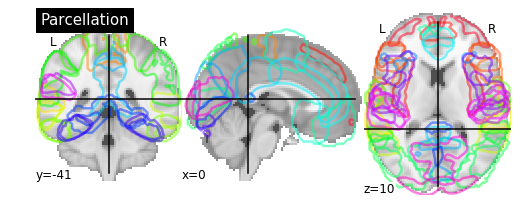

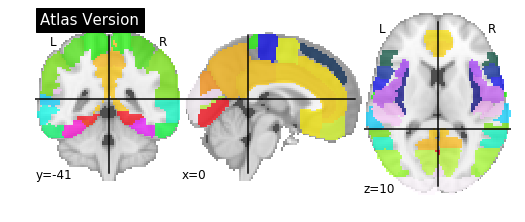

In [33]:
plotting.plot_prob_atlas(parcel, title="Parcellation", cut_coords=[0, -41, 10])
plotting.plot_roi(atlas, title="Atlas Version", cut_coords=[0, -41, 10])

### Calculate RDMs for each region for each group map

In [34]:
# get the average smoothed map for each contrast
group_map_files = get_mean_maps(smooth_out, contrast_names, save=True, rerun=args.rerun)

In [43]:
group_extraction_file = path.join(second_level_dir, 'Extracted_Data', 
                            'parcel-%s' % name,
                            'group-%s_parcel-%s_extraction.pkl' % (individual_file_type, parcel_name))
if path.exists(group_extraction_file) and not args.rerun:
    group_roi_contrasts = pickle.load(open(group_extraction_file, 'rb'))
else:
    group_roi_contrasts = extract_roi_vals(list(group_map_files.values()), parcel, threshold, 
                                           labels=parcel_labels, metadata=get_metadata(group_map_files),
                                           n_procs=args.n_procs) 
    pickle.dump(group_roi_contrasts, open(group_extraction_file, 'wb'))
group_RDMs = get_RDMs(group_roi_contrasts)

In [ ]:
# plot random RDM
label = np.random.choice(list(group_RDMs.keys()))
index = parcel_labels.index(label)
roi = get_ROI_from_parcel(parcel, index, threshold)
RDM = pd.DataFrame(group_RDMs[label], index=group_map_files.keys())
plot_RDM(RDM, roi, title=label, cluster=True)

#### RDM of RDMs

Each ROI has an RDM reflecting its "representation" of cognitive faculties probed by these contrasts. We can look at the similarity of RDMs to get a sense of the similarity of the cognitive fingerprint of individual regions

In [ ]:
def tril(square_mat):
    return square_mat[np.tril_indices_from(square_mat, -1)]

# similarity of RDMs
keys = list(group_RDMs.keys())
vectorized_RDMs = np.vstack([tril(group_RDMs[k]) for k in keys])
vectorized_RDMs = pd.DataFrame(vectorized_RDMs, index=keys)
RDM_of_RDMs = 1-vectorized_RDMs.T.corr()

In [ ]:
# visualize RDM of RDMs
sns.clustermap(RDM_of_RDMs, figsize=[15,15])

#### PCA of RDMs

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import minmax_scale
from scipy.spatial.distance import squareform
from itertools import combinations
pca = PCA(3)
pca_RDMs = pca.fit_transform(vectorized_RDMs)
scaled = minmax_scale(pca_RDMs)

# we can then color the first 3 PCA components (RGB) and create color mixtures reflecting the RDM signature
colors = np.array([[1,0,0], [0,1,0], [0,0,1]])
def combined_colors(array, colors=colors):
    return np.dot(colors, array)
colored_pca = np.apply_along_axis(combined_colors, 1, scaled)

In [ ]:
# compare RDM after dimensional reduction
i = np.random.randint(vectorized_RDMs.shape[0])
f, axes = plt.subplots(1,2,figsize=(12,5))
orig = vectorized_RDMs.iloc[i,:]
reconstruction = pca.inverse_transform(pca_RDMs[i,:])
corr = np.corrcoef(orig, reconstruction)[0,1]
sns.heatmap(squareform(orig), ax=axes[0])
sns.heatmap(squareform(reconstruction), ax=axes[1])
axes[0].set_title(vectorized_RDMs.index[i])
axes[1].set_title('PCA (%s) reconstruction, Corr: %0.2f' % (str(pca.n_components), corr))

In [ ]:
from matplotlib.colors import ListedColormap
cm = ListedColormap(colored_pca)
f=plt.figure(figsize=(12,8))
plotting.plot_prob_atlas(parcel, cmap=cm, view_type='filled_contours', figure=f, 
                         title="RDM -> PCA -> colors (1: Red, 2: Green, 3: Blue)")

In [ ]:
# we can also visualize the RDMs reflecting each of these first 3 components
from scipy.spatial.distance import squareform
def impulse(length, n):
    impulse = np.zeros(length)
    impulse[n] = 10
    return impulse
n_cols = 3
n_rows = pca.n_components//n_cols
f, axes = plt.subplots(n_rows, n_cols,
                      figsize = (5*n_cols, 5*n_rows))
axes = f.get_axes()
for i, component in enumerate(pca.components_):
    sns.heatmap(squareform(component), ax=axes[i])
    axes[i].set_title('PCA Components %s' % str(i+1))

### Calculate RDMs for each region for each subject-contrast

In [ ]:
extraction_file = path.join(second_level_dir, 'Extracted_Data', 
                            'parcel-%s' % name,
                            'individual-%s_parcel-%s_extraction.pkl' % (individual_file_type, parcel_name))
makedirs(path.dirname(extraction_file), exist_ok=True)
if path.exists(extraction_file) and not args.rerun:
    roi_contrasts = pickle.load(open(extraction_file, 'rb'))
else:
    roi_contrasts = extract_roi_vals(smooth_out, parcel, threshold, labels=parcel_labels, 
                                     metadata=get_metadata(map_files), n_procs=args.n_procs) 
    pickle.dump(roi_contrasts, open(extraction_file, 'wb'))
RDMs = get_RDMs(roi_contrasts)

In [ ]:
# plot random RDM
label = np.random.choice(list(RDMs.keys()))
index = parcel_labels.index(label)
roi = get_ROI_from_parcel(parcel, index, threshold)
plot_RDM(RDMs[label], roi, title=label, cluster=True)

## RSA Searchlight
http://www.pymvpa.org/examples/rsa_fmri.html

#### Apply parcellations

In [ ]:
"""
# ********************************************************
# Set up parcellation
# ********************************************************

#******************* Estimate parcellation from data ***********************
print('Creating ICA based parcellation')


# group map files by subject
subject_ids = np.unique([f.split(os.sep)[-2].split('_')[0] for f in map_files])
subject_map_files = []
for s in subject_ids:
    subject_map_files.append(image.concat_imgs([f for f in map_files if s in f]))






# ********************************************************
# Reduce dimensionality of contrasts
# ********************************************************
def split_index(projections_df):
    subj = [f.split('_')[0] for f in projections_df.index]
    contrast = ['_'.join(f.split('_')[1:]) for f in projections_df.index]
    projections_df.insert(0, 'subj', subj)
    projections_df.insert(1, 'contrast', contrast)
    
    
parcellation_files = [('smith70', smith_networks),
                      ('canica20', 
                       join(output_dir, 'canica20_explicit_contrasts.nii.gz')),
                      ('canica50', 
                       join(output_dir, 'canica50_explicit_contrasts.nii.gz')),
                       ('canica70', 
                       join(output_dir, 'canica70_explicit_contrasts.nii.gz'))
                       ]

for parcellation_name, parcellation_file in parcellation_files:
    projection_filey = join(output_dir, '%s_projection.json' % parcellation_name)
    mask_file = join(output_dir, 'group_mask.nii.gz')
    projections_df = create_projections_df(parcellation_file, mask_file, 
                                           data_dir, tasks, projection_filey)
    
    # create a subject x neural feature vector where each column is a component
    # for one contrast
    neural_feature_mat = create_neural_feature_mat(projections_df,
                                                   filename=join(output_dir, 
                                                        '%s_neural_features.json'  
                                                        % parcellation_name))
"""